# kNN - Zillow

## Libraries

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers
from sklearn import neighbors
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor #continous variables
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [34]:
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Delete previous DFs 

In [ ]:
#del df_2017, df_train, dataset,df_2016

## Import files

In [3]:
# read properties2016 file
prop_2016 = pd.read_csv("properties_2016.csv", low_memory=False)
# read properties2017 file
prop_2017 = pd.read_csv("properties_2017.csv", low_memory=False)
# read train2016 file 
train_2016 = pd.read_csv("train_2016_v2.csv",
                             parse_dates=["transactiondate"])
# read train2017 file 
train_2017 = pd.read_csv("train_2017.csv", 
                             parse_dates=["transactiondate"])

In [4]:
train_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [5]:
train_2016.shape

(90275, 3)

In [6]:
prop_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [7]:
prop_2016.shape

(2985217, 58)

### Merge Files

In [47]:
df_2016 = train_2016.merge(prop_2016, how='left', on='parcelid')
#df_2017 = train_2017.merge(prop_2017, how='left', on='parcelid')

In [48]:
df_2016.shape

(90275, 60)

In [49]:
df_2016.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.028,2016-01-01,1.000,nan,nan,2.000,3.000,nan,4.000,2.000,nan,nan,1684.000,1684.000,nan,nan,nan,nan,6037.000,nan,2.000,nan,nan,NaN,2.000,34280990.000,-118488536.000,7528.000,nan,nan,nan,nan,nan,0100,261.000,LARS,60371066.461,12447.000,3101.000,31817.000,96370.000,0.000,nan,nan,nan,1.000,nan,nan,1959.000,nan,NaN,122754.000,360170.000,2015.000,237416.000,6735.880,NaN,nan,60371066461001.000
1,14366692,-0.168,2016-01-01,nan,nan,nan,3.500,4.000,nan,nan,3.500,nan,nan,2263.000,2263.000,nan,nan,nan,nan,6059.000,nan,3.000,2.000,468.000,NaN,nan,33668120.000,-117677556.000,3643.000,nan,nan,nan,nan,nan,1,261.000,NaN,60590524.222,32380.000,1286.000,nan,96962.000,0.000,nan,1.000,nan,nan,nan,nan,2014.000,nan,NaN,346458.000,585529.000,2015.000,239071.000,10153.020,NaN,nan,nan
2,12098116,-0.004,2016-01-01,1.000,nan,nan,3.000,2.000,nan,4.000,3.000,nan,nan,2217.000,2217.000,nan,nan,nan,nan,6037.000,nan,3.000,nan,nan,NaN,2.000,34136312.000,-118175032.000,11423.000,nan,nan,nan,nan,nan,0100,261.000,PSR6,60374638.003,47019.000,3101.000,275411.000,96293.000,0.000,nan,nan,nan,1.000,nan,nan,1940.000,nan,NaN,61994.000,119906.000,2015.000,57912.000,11484.480,NaN,nan,60374638003004.000
3,12643413,0.022,2016-01-02,1.000,nan,nan,2.000,2.000,nan,4.000,2.000,nan,nan,839.000,839.000,nan,nan,nan,nan,6037.000,nan,2.000,nan,nan,NaN,2.000,33755800.000,-118309000.000,70859.000,nan,nan,nan,nan,nan,010C,266.000,LAR3,60372963.002,12447.000,3101.000,54300.000,96222.000,0.000,nan,nan,nan,1.000,nan,nan,1987.000,nan,NaN,171518.000,244880.000,2015.000,73362.000,3048.740,NaN,nan,60372963002002.000
4,14432541,-0.005,2016-01-02,nan,nan,nan,2.500,4.000,nan,nan,2.500,nan,nan,2283.000,2283.000,nan,nan,nan,nan,6059.000,nan,2.000,2.000,598.000,NaN,nan,33485643.000,-117700234.000,6000.000,1.000,nan,nan,nan,1.000,122,261.000,NaN,60590423.381,17686.000,1286.000,nan,96961.000,8.000,nan,1.000,nan,nan,nan,nan,1981.000,2.000,NaN,169574.000,434551.000,2015.000,264977.000,5488.960,NaN,nan,60590423381006.000


In [50]:
df_train = df_2016.copy()

In [51]:
df_train.shape

(90275, 60)

### Compare property dataset with the merged data set for potential sample improvements

In [37]:
catcols = ['parcelid','airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in df_train.columns if x not in catcols]

In [55]:
print(prop_2016.shape)
prop_df = prop_2016.drop(catcols,axis=1)
print(prop_df.shape)
t = prop_df.describe().transpose().reset_index()
prop_stats = t.filter(['index','mean','std','50%'], axis=1)
prop_stats.columns = ['features','p_mean','p_std','p_median']
prop_stats

(2985217, 58)
(2985217, 34)


,features,p_mean,p_std,p_median
0,basementsqft,646.883,538.793,534.000
1,bathroomcnt,2.209,1.078,2.000
2,bedroomcnt,3.089,1.276,3.000
3,calculatedbathnbr,2.299,1.001,2.000
4,finishedfloor1squarefeet,1380.630,632.869,1283.000
5,calculatedfinishedsquarefeet,1827.162,1819.780,1572.000
6,finishedsquarefeet12,1760.001,971.061,1539.000
7,finishedsquarefeet13,1178.901,357.073,1296.000
8,finishedsquarefeet15,2739.187,5447.428,2172.000
9,finishedsquarefeet50,1388.945,664.489,1284.000


In [58]:
print(df_train.shape)
df_train_2 = df_train.drop(catcols,axis=1)
print(df_train_2.shape)
t2 = df_train_2.describe().transpose().reset_index()
train_stats = t2.filter(['index','mean','std','50%'], axis=1)
train_stats.columns = ['features','t_mean','t_std','t_median']
train_stats

(90275, 60)
(90275, 36)


,features,t_mean,t_std,t_median
0,logerror,0.011,0.161,0.006
1,basementsqft,713.581,437.434,616.000
2,bathroomcnt,2.279,1.004,2.000
3,bedroomcnt,3.032,1.156,3.000
4,calculatedbathnbr,2.309,0.976,2.000
5,finishedfloor1squarefeet,1347.974,652.399,1244.000
6,calculatedfinishedsquarefeet,1773.186,928.162,1540.000
7,finishedsquarefeet12,1745.455,909.941,1518.000
8,finishedsquarefeet13,1404.545,110.108,1440.000
9,finishedsquarefeet15,2380.090,1068.207,2104.500


In [83]:
merged_stats = pd.merge(prop_stats,train_stats,how='left',on='features')
merged_stats['mean_pct_chg'] = ((merged_stats['p_mean'] - merged_stats['t_mean']) / (merged_stats['t_mean']))*100
merged_stats['std_pct_chg'] = ((merged_stats['p_std'] - merged_stats['t_std']) / (merged_stats['t_std']))*100
merged_stats['median_pct_chg'] = ((merged_stats['p_median'] - merged_stats['t_median']) / (merged_stats['t_median']))*100
merged_pct_chg_df = merged_stats.filter(['features','mean_pct_chg','std_pct_chg','median_pct_chg'],axis=1)
merged_pct_chg_df

,features,mean_pct_chg,std_pct_chg,median_pct_chg
0,basementsqft,-9.347,23.171,-13.312
1,bathroomcnt,-3.085,7.317,0.000
2,bedroomcnt,1.883,10.327,0.000
3,calculatedbathnbr,-0.431,2.516,0.000
4,finishedfloor1squarefeet,2.423,-2.994,3.135
5,calculatedfinishedsquarefeet,3.044,96.063,2.078
6,finishedsquarefeet12,0.833,6.717,1.383
7,finishedsquarefeet13,-16.065,224.293,-10.000
8,finishedsquarefeet15,15.088,409.960,3.207
9,finishedsquarefeet50,2.464,-1.368,2.885


## Missing data

In [61]:
sumNullRws = df_train.isnull().sum()
sumNullRws = pd.DataFrame(sumNullRws).reset_index()
#sumNullRws.reset_index()
sumNullRws.columns = ['features','missing_data']
sumNullRws['pct_total'] = round(sumNullRws['missing_data'] / df_train.shape[0] ,4)
sumNullRws = sumNullRws.sort_values('missing_data',ascending=False)
sumNullRws

,features,missing_data,pct_total
8,buildingclasstypeid,90259,1.000
15,finishedsquarefeet13,90242,1.000
43,storytypeid,90232,1.000
5,basementsqft,90232,1.000
48,yardbuildingsqft26,90180,0.999
51,fireplaceflag,90053,0.998
4,architecturalstyletypeid,90014,0.997
45,typeconstructiontypeid,89976,0.997
18,finishedsquarefeet6,89854,0.995
11,decktypeid,89617,0.993


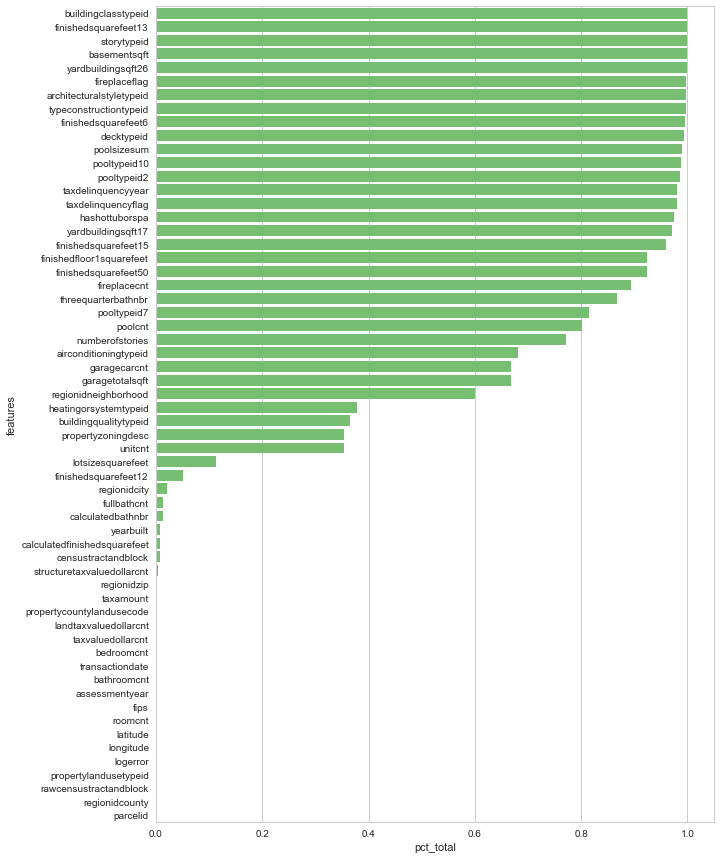

In [62]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,15)) # new plot
sns.set_color_codes("muted")
sns.barplot(y='features', x='pct_total', data=sumNullRws,color="g")

In [87]:
prop_sumNullRws = prop_2016.isnull().sum()
prop_sumNullRws = pd.DataFrame(prop_sumNullRws).reset_index()
#sumNullRws.reset_index()
prop_sumNullRws.columns = ['features','prop_missing_data']
prop_sumNullRws['prop_pct_total'] = round(prop_sumNullRws['prop_missing_data'] / prop_2016.shape[0] ,4)
prop_sumNullRws = prop_sumNullRws.sort_values('prop_missing_data',ascending=False)
prop_sumNullRws

,features,prop_missing_data,prop_pct_total
41,storytypeid,2983593,1.000
3,basementsqft,2983589,1.000
46,yardbuildingsqft26,2982570,0.999
49,fireplaceflag,2980054,0.998
2,architecturalstyletypeid,2979156,0.998
43,typeconstructiontypeid,2978470,0.998
13,finishedsquarefeet13,2977545,0.997
6,buildingclasstypeid,2972588,0.996
9,decktypeid,2968121,0.994
16,finishedsquarefeet6,2963216,0.993


In [88]:
test_df = pd.merge(prop_sumNullRws ,sumNullRws, how='left',on='features' )
test_df

,features,prop_missing_data,prop_pct_total,missing_data,pct_total
0,storytypeid,2983593,1.000,90232,1.000
1,basementsqft,2983589,1.000,90232,1.000
2,yardbuildingsqft26,2982570,0.999,90180,0.999
3,fireplaceflag,2980054,0.998,90053,0.998
4,architecturalstyletypeid,2979156,0.998,90014,0.997
5,typeconstructiontypeid,2978470,0.998,89976,0.997
6,finishedsquarefeet13,2977545,0.997,90242,1.000
7,buildingclasstypeid,2972588,0.996,90259,1.000
8,decktypeid,2968121,0.994,89617,0.993
9,finishedsquarefeet6,2963216,0.993,89854,0.995


## **Imputation**

### fillna_knn function & zoningcode2int
>
> The functions are used to impute using kNN based on longitude and latitude
>
> The funcitons were pulled from [here.](https://www.kaggle.com/nikunjm88/carefully-dealing-with-missing-values#)

In [ ]:
def fillna_knn( df, base, target, fraction = 1, threshold = 10, n_neighbors = 5 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = n_neighbors
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'predicting' )
    Z = clf.predict(df.loc[miss, base])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df' )    
        df.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unperdictable data: ', numunperdicted )
        return enc
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )



In [ ]:
#function to deal with variables that are actually string/categories
def zoningcode2int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

    print('fit and transform')
    df[ target ]= enc.fit_transform( df[ target ].values )
    print( 'num of categories: ', enc.classes_.shape  )
    df.loc[ storenull, target ] = np.nan
    print('recover the nan value')
    return enc



In [ ]:
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'lotsizesquarefeet', fraction = 0.15, n_neighbors = 1 )

### Test using Scikit Learn kNN and not the above function
> 1) Need to fill in lotsize first - used long & lat (fillna_knn function)
>
> 2) Fill in other pull related NaNs - zero and or mean
>
> 3) leave NaNs in the targeted field (ie poolsize)
>
> 4) run code 
>> if data type is object or categorical need to use the encoder function (LabelEncoder or HotEncoder)

In [ ]:
# "0 pools"
df_train.poolcnt.fillna(0,inplace = True)
df_train.head(2)

In [ ]:
# "0 hot tubs or spas"
df_train.hashottuborspa.fillna(0, inplace = True)
df_train.head(2)

In [ ]:
# Convert "True" to 1
df_train.hashottuborspa.replace(to_replace = True, value = 1,inplace = True)
df_train.head(2)

In [ ]:
print(df_train['hashottuborspa'].value_counts())

In [ ]:
# Set properties that have a pool but no info on poolsize equal to the median poolsize value.
#df_train.loc[df_train.poolcnt==1, 'poolsizesum'] = df_train.loc[df_train.poolcnt==1, 'poolsizesum'].fillna(df_train[df_train.poolcnt==1].poolsizesum.median())

In [ ]:
df_train.loc[df_train.poolcnt==0, 'poolsizesum']=0

In [ ]:
df_train.pooltypeid2.fillna(0,inplace = True)

In [ ]:
#df_train.poolsizesum.fillna(0, inplace = True) #don't fillna since using kNN
#print(df_train['poolsizesum'].value_counts())
df_train.head(3)

In [ ]:
df_train.pooltypeid7.fillna(0,inplace = True)
df_train.pooltypeid10.fillna(0,inplace = True)
df_train.calculatedfinishedsquarefeet.fillna(0,inplace=True)

In [ ]:
print(df_train['lotsizesquarefeet'].value_counts())
print(df_train['lotsizesquarefeet'].isnull().sum())
df_train[df_train['lotsizesquarefeet'].isnull()].head()

In [ ]:
test_df = df_train.filter(['poolsizesum','pooltypeid7','pooltypeid2','pooltypeid10','bedroomcnt','bathroomcnt','lotsizesquarefeet','calculatedfinishedsquarefeet'], axis=1)

In [60]:
# 
y= df_train['poolsizesum']
X= df_train.filter(['pooltypeid7','pooltypeid2','pooltypeid10','bedroomcnt','bathroomcnt','lotsizesquarefeet','calculatedfinishedsquarefeet'], axis=1)
X = pd.DataFrame(X)
#X_np = np.array(X)
#y_np = np.array(y)
neigh = neighbors.KNeighborsClassifier(n_neighbors=5, weights = 'uniform')
neigh.fit(X, y) 
#df['col_name'] = pd.to_numeric(df['col_name'], errors='coerce')
print(neigh.score(X,y)) # regression only? returned value of .98...
#print(neigh.predict([[1.1]])) # examples 
#print(neigh.predict_proba([[0.9]])) 


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#fillna_knn(df=test_df,
 #          base=['pooltypeid7','pooltypeid2','pooltypeid10','bedroomcnt','bathroomcnt','lotsizesquarefeet','calculatedfinishedsquarefeet'],
  #         target = 'poolsizesum' )

In [ ]:
# drop object variables and try again
# hashottuborspa -> convert
# taxdelinquencyflag    -> drop
# fireplaceflag         -> drop
# propertycountylandusecode       category
# propertyzoningdesc              category
dataset = df_train.copy()

## **// Old code //**

In [ ]:
t = df_2016.iloc[:,0:3]

In [ ]:
print(df_train['lotsizesquarefeet'].isnull().sum())
df_train[df_train['parcelid']==17177301].head()

In [ ]:
le = LabelEncoder()
dataset['hashottuborspa'] = le.fit_transform(dataset['hashottuborspa'])

In [ ]:
for column in dataset.columns:
    if dataset[column].dtype == type(object):
        le = LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])

In [ ]:
def data_reduce(dataframe):
    '''
    input - dataframe
    output - dataframe reduction
    '''
    print(dataframe.info(memory_usage='deep'))
    for c, dtype in zip(dataframe.columns, dataframe.dtypes):
        if dtype == np.float64:
            dataframe[c] = dataframe[c].astype(np.float32)
        elif dtype == np.int64:
            dataframe[c] = dataframe[c].astype(np.int32)
        elif dtype == np.object:
            dataframe[c] = dataframe[c].astype('category')
    return dataframe.info(memory_usage='deep')
